# Clothing Fashion Model

The purpose of this notebook is to create a classification model for different clothing items. The open-source image dataset used for training the classifier on is from github alexygrigorev -> https://github.com/alexeygrigorev/clothing-dataset. I had tried Fashion minst dataset, it was easy to work with and had good test set accuracy but it did not adapt well to real world images, so I found a dataset with higher quality images with normal backgrounds rather than transparent and cropped images

In [1]:
# base libraries for manipulating data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# to modify images
from PIL import Image

from sklearn.model_selection import train_test_split

# for model fitting
import tensorflow as tf
import tensorflow_hub as hub

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# finding best hypter parameters for the conv2d model
import kerastuner as kt

import time
import pprint

# to oversample some images for better class distribution
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.image import ImageDataGenerator
from skimage import transform

import random


C:\Users\Qasim\AppData\Local\Temp/ipykernel_25460/1477486942.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


## Data Input

In [54]:
dataset_path = "..\clothing-dataset\images.csv"
dataset = pd.read_csv(dataset_path)

In [55]:
dataset.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


The data directory contains the csv shown above and images stored as .jpg. Each name in the 'image' column corresponds to the image in the images directory

In [56]:
# lets see the distribution of classes
gb_categories = dataset.groupby('label').count()

<AxesSubplot:xlabel='label'>

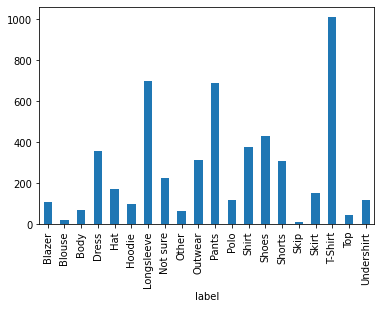

In [57]:
gb_categories['image'].plot.bar()

We can quickly see that the distribution of records per class is not great. Most of the images are for T-shirts and a few in between and some such as skirt have very few records. In order to make a better classifer we need more balanced dataset of images

In [58]:
# lets narrow down number of classes which have relatively high number of records, so when we upscale dataset we'll have a few more examples to build from
gb_categories[gb_categories['image'] > 200]

,image,sender_id,kids
label,,,
Dress,357,357,357
Longsleeve,699,699,699
Not sure,228,228,228
Outwear,312,312,312
Pants,692,692,692
Shirt,378,378,378
Shoes,431,431,431
Shorts,308,308,308
T-Shirt,1011,1011,1011


## Prepairing dataset

In [59]:
# Chose a subset of classes with more data
dict_labels = {'T-Shirt':0, 'Pants':1, 'Longsleeve':2, 'Dress':3, 'Shoes':4}
lookup = {value: key for key, value in dict_labels.items()}

In [60]:
# label encode the class names to prep data for training for tensorflow
dataset = dataset.query(f"label in {[*dict_labels]}")

In [61]:
# taking the X as image and y as label for classification
df_main = dataset[['image','label']]
df_main['y'] = df_main['label'].replace(dict_labels)

C:\Users\Qasim\AppData\Local\Temp/ipykernel_25780/2490017833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main['y'] = df_main['label'].replace(dict_labels)


In [62]:
# add image path column next image names, so they are easy to extract into images
df_main['img_path'] = df_main['image'].apply(lambda x: f"../clothing-dataset/images/{x}.jpg")

In [63]:
# store images data in it
dataset = []

In [64]:
# params for image size
img_w, img_h = 64, 64

In [65]:
# load and prepare the image
def load_image(filename):
	# load the image as grayscale
	img = load_img(filename, grayscale=True, target_size=(img_w,img_h))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel, as we don't need very high quality images for training 
	img = img.reshape(img_w, img_h, 1)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

In [66]:
# read images from directory and save them in numpy array
for i,r in df_main.iterrows():
    try:
        im = load_image(r['img_path'])
        dataset.append([im,r['y']])
    except:
        print(f"error img -> {r['img_path']}")

c:\Users\Qasim\anaconda3\envs\ai-env\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [67]:
# read the dataset as numpy array
dataset = np.array(dataset)

C:\Users\Qasim\AppData\Local\Temp/ipykernel_25780/1372529306.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dataset = np.array(dataset)


In [68]:
# current dataset with images
dataset.shape

(3190, 2)

In [69]:
# convert to right data type as errors show up for incorrect type in model building
X = np.stack(dataset[:,0]).astype('float32')
y = dataset[:,1].astype('uint8')

## Upsample images dataset using random sample library

In [70]:
# reshape dataset to prepare for upsampling, it will allow us to have more even distribution of images for each class
reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomOverSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
X = oversampled_X.reshape(-1,img_w,img_h,1)
y = oversampled_y

In [71]:
# we can already see that we have goo amount of images 
X.shape

(5055, 64, 64, 1)

In [72]:
from collections import Counter

Counter(y)
# we can see all classes have same amount of images, most probably duplicaed

Counter({0: 1011, 4: 1011, 1: 1011, 3: 1011, 2: 1011})

## Apply image augmentation on upsampled dataset of images

In [73]:
# now we apply rotation and flips on image to have more divers set of images for training
angles = [-90,90]
def applyRotaion(img):
    rand_choice = random.choice([0,1])
    img = transform.rotate(img,angle=angles[rand_choice])
    if rand_choice == 0:
        img = np.fliplr(img)
    else:
        img= np.flipud(img)
    return img

# randomly rotate images to add a bit of diversity to images that have been duplicated to upscale data
for i in range(len(X)):
    X[i] = applyRotaion(X[i])

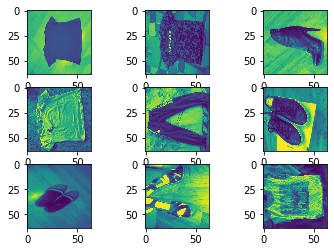

In [74]:
# visualize the dataset
fig, axs = plt.subplots(3,3)

counter_ = 0
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(X[counter_])
        counter_+=1

In [38]:
# set up train and test sets
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.05, random_state=42)

In [39]:
x_train.shape

(4802, 64, 64, 1)

## Setting Model Paramters

In [40]:
# using function as we will pass it to keras tuner to find best hyper parameters for us and save that model
def model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((img_w, img_h,1)))

    hp_fe_11 = hp.Int('filter_exp_11', min_value=3, max_value=7, step=1)
    hp_fe_12 = hp.Int('filter_exp_12', min_value=3, max_value=7, step=1)
    hp_fs_11 = hp.Int('filter_size_11',  min_value=2, max_value=6, step=1)
    hp_fs_12 = hp.Int('filter_size_12',  min_value=2, max_value=6, step=1)
    hp_mps_1 = hp.Int('max_pool_size_1', min_value=2, max_value=6, step=1)

    model.add(tf.keras.layers.Conv2D(2**hp_fe_11, hp_fs_11, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(2**hp_fe_12, hp_fs_12, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(hp_mps_1))
    model.add(tf.keras.layers.Dropout(0.2))

    hp_dense_exp_1 = hp.Int('dense_exp_1', min_value=5, max_value=9, step=1)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=2**hp_dense_exp_1, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(5, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

    return model

In [41]:
# We used Keras Tuner, to find the best hyperparameters for our models
def model_tuner(model_builder, dir):

    tuner = kt.Hyperband(model_builder,
                        objective='val_accuracy',
                        max_epochs=10,
                        factor=3)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    tuner.search(x_train, y_train, validation_split=0.3, epochs=50, callbacks=[early_stopping])
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    pp = pprint.PrettyPrinter(indent=1)
    print("\n-- Best Model Hyper params --\n ")
    pp.pprint(best_hps.values)

    model = tuner.hypermodel.build(best_hps)

    print("\n-- Model Performance --\n ")
    

    history = model.fit(x_train, y_train, epochs=50, callbacks=[early_stopping], validation_split=0.3, verbose=2)
    score, acc = model.evaluate(x_test, y_test)
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) 
    print()
    print('Best epoch  : %d' % (best_epoch,))
    print("Best val acc: %s" % (round(max(history.history['val_accuracy']), 4)))
    print("    Test acc: %s" % (round(acc, 4)))

    return model

In [42]:
trained_model = model_tuner(model, 'model')

Trial 30 Complete [00h 00m 07s]
val_accuracy: 0.8306731581687927

Best val_accuracy So Far: 0.9070090055465698
Total elapsed time: 00h 02m 16s
INFO:tensorflow:Oracle triggered exit

-- Best Model Hyper params --
 
{'dense_exp_1': 7,
 'filter_exp_11': 3,
 'filter_exp_12': 6,
 'filter_size_11': 3,
 'filter_size_12': 5,
 'max_pool_size_1': 6,
 'tuner/bracket': 0,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/round': 0}

-- Model Performance --
 
Epoch 1/50
106/106 - 1s - loss: 1.2631 - accuracy: 0.5046 - val_loss: 0.8092 - val_accuracy: 0.7224
Epoch 2/50
106/106 - 1s - loss: 0.7011 - accuracy: 0.7465 - val_loss: 0.6243 - val_accuracy: 0.7967
Epoch 3/50
106/106 - 1s - loss: 0.5317 - accuracy: 0.8081 - val_loss: 0.5050 - val_accuracy: 0.8272
Epoch 4/50
106/106 - 1s - loss: 0.4282 - accuracy: 0.8489 - val_loss: 0.4639 - val_accuracy: 0.8314
Epoch 5/50
106/106 - 1s - loss: 0.3614 - accuracy: 0.8685 - val_loss: 0.4426 - val_accuracy: 0.8397
Epoch 6/50
106/106 - 1s - loss: 0.3530 - ac

In [43]:
trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 8)         80        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        12864     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               819328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [44]:
# save the best model
trained_model.save('best_model.h5')

In [3]:
model = tf.keras.models.load_model('./best_model.h5')

In [46]:
# take some random image online and test model
test_img = load_image('static\images\photo-1542291026-7eec264c27ff.jpg')

c:\Users\Qasim\anaconda3\envs\ai-env\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


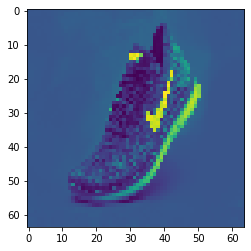

In [47]:
plt.imshow(test_img)

In [48]:
# it classifes it correctly
lookup[np.argmax(model.predict(test_img.reshape(1,64,64,1)))]

'Shoes'

In [49]:
img = load_image('../clothing-dataset/unknown.png')

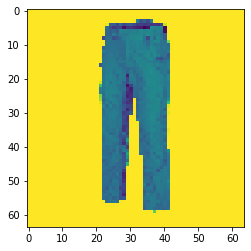

In [50]:
plt.imshow(img)

In [51]:
lookup[np.argmax(model.predict(img.reshape(1,64,64,1)))]

'Pants'

In [2]:
file_path = 'static\images\pexels-photo.webp'

In [4]:
img_w, img_h = 64,64

# load the image as grayscale
img = load_img(file_path, grayscale=True, target_size=(img_w,img_h))
# convert to array
img = img_to_array(img)
# reshape into a single sample with 1 channel, as we don't need very high quality images for training 
img = img.reshape(img_w, img_h, 1)
# prepare pixel data
img = img.astype('float32')
img = img / 255.0


c:\Users\Qasim\anaconda3\envs\ai-env\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


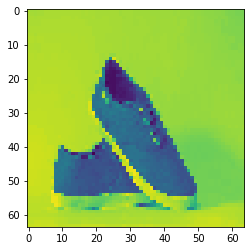

In [5]:
plt.imshow(img)

In [7]:
img.shape

(64, 64, 1)

In [8]:

# make prediction
# pred = model.predict(img.reshape(1,64,64,1))